In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import math
import keras
from random import shuffle
from keras.models import Sequential, Model
from keras.layers import Dense,Bidirectional
from keras.layers import LSTM, Flatten, Input
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed, Conv1D, Conv2D, MaxPooling1D, GlobalMaxPooling1D,Dropout
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.optimizers import Adam

In [2]:
path = os.path.normpath('/Users/mariekorneliusson/documents/AiSports/Strike_Data_As_Np')

In [3]:
X_First = np.load(path + '/' + 'X_First_Skier.npy')
Y_First = np.load(path + '/' + 'Y_First_Skier.npy')
feature_list_First = []
with open(path + "/keys_First_Skier.txt", "r") as f:
      for line in f:
        feature_list_First.append(line.strip('\n'))

In [4]:
X_Second = np.load(path + '/' + 'X_Second_Skier.npy')
Y_Second = np.load(path + '/' + 'Y_Second_Skier.npy')
feature_list_Second = []
with open(path + "/keys_Second_Skier.txt", "r") as f:
      for line in f:
        feature_list_Second.append(line.strip('\n'))

In [5]:
X_Third = np.load(path + '/' + 'X_Third_Skier.npy')
Y_Third = np.load(path + '/' + 'Y_Third_Skier.npy')
feature_list_Third = []
with open(path + "/keys_Third_Skier.txt", "r") as f:
      for line in f:
        feature_list_Third.append(line.strip('\n'))

In [6]:
feature_Dict = {i:feature_list_Second[i] for i in range(len(feature_list_Second)-1)}
print(len(feature_Dict))

17


In [7]:
print(X_First.shape)
print(X_Second.shape)
print(X_Third.shape)
print(Y_First.shape)
print(Y_Second.shape)
print(Y_Third.shape)

(452, 140, 22)
(382, 140, 18)
(844, 140, 22)
(452, 4)
(382, 4)
(844, 4)


In [8]:
def split_to_test_train_data(X_List,Y_List,ratio,time_step,dimX,nbr_of_classes):
    
    nbr_of_data = len(X_List)
    min_samples = min([x.shape[0] for x in X_List])
    h = int((1-ratio)*min_samples)
    nbr_of_test = [x.shape[0]-h for x in X_List]
    X = np.zeros((h*nbr_of_data,time_step,dimX))
    Y = np.zeros((h*nbr_of_data,nbr_of_classes))
    X_Test_List = [np.zeros((sum(nbr_of_test),time_step,dimX))]
    Y_Test_List = [np.zeros((sum(nbr_of_test),nbr_of_classes))]
    
    for i in range(nbr_of_data):
        x_d = np.zeros((nbr_of_test[i],time_step,dimX))
        y_d = np.zeros((nbr_of_test[i],nbr_of_classes))
        X_Test_List.append(x_d)
        Y_Test_List.append(y_d)

    test_samp_prev = 0 
    for i in range(nbr_of_data):
        x = X_List[i][:,:,:dimX]
        y = Y_List[i]
        test_samp = nbr_of_test[i] + test_samp_prev
        X[h*i:h*(i+1),:,:] = x[:h,:,:]
        Y[h*i:h*(i+1),:] = y[:h,:]
        X_Test_List[0][test_samp_prev:test_samp,:,:] = x[h:,:,:]
        Y_Test_List[0][test_samp_prev:test_samp,:] = y[h:,:]
        X_Test_List[i+1] = x[h:,:,:]
        Y_Test_List[i+1] = y[h:,:]
        test_samp_prev = test_samp
        
    return X,Y,X_Test_List,Y_Test_List

In [9]:
dim_X = len(feature_Dict)
X_List = [X_First,X_Second,X_Third]
Y_List = [Y_First,Y_Second,Y_Third]
ratio = 0.2
time_step = 140
nbr_of_classes = 4
X,Y,X_Test_List,Y_Test_List = split_to_test_train_data(X_List,Y_List,ratio,time_step,dim_X,nbr_of_classes)
X_Test = X_Test_List[0]
Y_Test = Y_Test_List[0]

In [10]:
print(X.shape)
print(Y.shape)
print(X_Test.shape)
print(Y_Test.shape)

(915, 140, 17)
(915, 4)
(763, 140, 17)
(763, 4)


In [82]:
def get_strike(strike,strike_l,pad):
    
    for j in range(strike_l-3):
        if strike[j,1] == strike[j+1,1] == strike[j+2,1] == pad:
            plot_strike = strike[0:j-1,1]
            time_strike = strike[0:j-1,0]
            break
        elif strike[strike_l-2,0] > 0:
            plot_strike = strike[:,1]
            time_strike = strike[:,0]
            break
    
    return plot_strike,time_strike

In [83]:
def change_time_axis_for_plot(X,delta_t):
    
    nbr_of_samples = X.shape[0]
    t = 0
    for i in range(nbr_of_samples):
        for j in range(140):
            X[i,j,0] = t*delta_t
            t = t + 1
    
    return X

In [84]:
def plot_skiedata(true_Y,X,figure):

    nbr_of_classes = 4
    colorDict = {0:'r',1:'fuchsia',2:'deeppink',3:'orange'}
    nameDict = {0:'Gear 2',1:'Gear 3',2:'Gear 4',3:'Double','Gear 2':0,'Gear 3':1,'Gear 4':2,'Double':3}
    nbr_of_test = X.shape[0]
    strike_l = X.shape[1]
    pad = 0

    for c in range(nbr_of_classes):
        true_c = np.where(true_Y == c)[0]
        strike_true = []
        strike_pred = []
        time_true = []
        time_pred = []
        for i in range(true_c.shape[0]):
            strike = X[true_c[i],:,:]
            t_strike,t_time = get_strike(strike,strike_l,pad)
            strike_true.extend(t_strike)
            time_true.extend(t_time)

        plt.figure(figure,figsize=(15, 4))
        plt.title('True gear')
        plt.scatter(time_true,strike_true,label = 'True class: ' + nameDict[c],color =  colorDict[c], alpha = 1)
        plt.legend()
        #plt.axis([280, 320, 0, 400])
    figure = figure + 1
    return figure

In [85]:
delta_t = 0.02
X = change_time_axis_for_plot(X,delta_t)
X_Test = change_time_axis_for_plot(X_Test,delta_t)

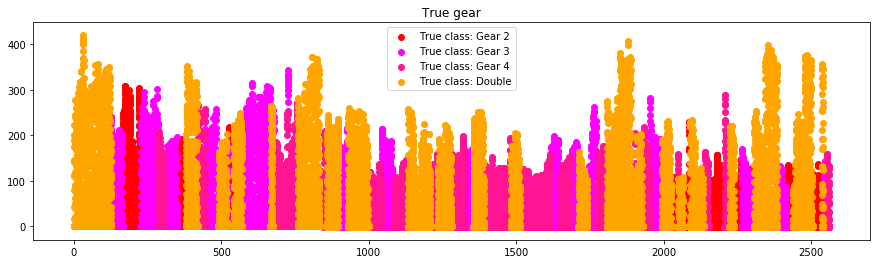

In [86]:
true_Y = np.argmax(Y,axis = 1)
figure = plot_skiedata(true_Y,X,0)

In [28]:
def LSTM_Two_Dense_26():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    print(sequence_input.shape)
    x = LSTM(26,return_sequences=True)(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    print(x.shape)
    x = Flatten()(x)
    print(x.shape)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def LSTM_Two_Dense():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    print(sequence_input.shape)
    x = LSTM(64,return_sequences=True)(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    print(x.shape)
    x = Flatten()(x)
    print(x.shape)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def LSTM_Two_Dense():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    print(sequence_input.shape)
    x = LSTM(100,return_sequences=True)(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    print(x.shape)
    x = Flatten()(x)
    print(x.shape)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def BLSTM_Two_Dense():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    print(sequence_input.shape)
    x = Bidirectional(LSTM(64,return_sequences=True))(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    print(x.shape)
    x = Flatten()(x)
    print(x.shape)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def CNN_One_Layer():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 26, activation='relu', padding = "same")(sequence_input)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model 

In [31]:
from keras.models import load_model
model = load_model('LSTM_26_1_2_3.h5')
predY = model.predict(X_Test[:,:,1:])
print(predY.shape)
pred_Y = np.argmax(predY,axis = 1)
true_Y = np.argmax(Y_Test,axis = 1)
acc = accuracy_score(true_Y,pred_Y)
print("Accuracy: %.2f" % acc)

(763, 4)
Accuracy: 0.90


In [21]:
model = BLSTM_Two_Dense()
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=5)
mCp = ModelCheckpoint('BLSTM_1_2_3.h5', monitor='val_loss', save_best_only=True)
history = model.fit(X[:,:,1:], Y, epochs=20, batch_size=1, validation_data=(X_Test[:,:,1:],Y_Test),shuffle = True,callbacks = [eS,mCp])

(?, 140, 16)
(?, 140, 140)
(?, ?)
Train on 915 samples, validate on 763 samples
Epoch 1/20
915/915 [==============================] - 227s 248ms/step - loss: 0.5173 - acc: 0.8098 - val_loss: 0.3708 - val_acc: 0.8558
Epoch 2/20
915/915 [==============================] - 212s 232ms/step - loss: 0.1821 - acc: 0.9421 - val_loss: 0.3045 - val_acc: 0.8676
Epoch 3/20
915/915 [==============================] - 207s 227ms/step - loss: 0.0747 - acc: 0.9825 - val_loss: 0.3183 - val_acc: 0.8781
Epoch 4/20
915/915 [==============================] - 2108s 2s/step - loss: 0.0358 - acc: 0.9945 - val_loss: 0.3083 - val_acc: 0.8847
Epoch 5/20
915/915 [==============================] - 204s 223ms/step - loss: 0.0185 - acc: 0.9978 - val_loss: 0.2693 - val_acc: 0.8925
Epoch 6/20
915/915 [==============================] - 209s 228ms/step - loss: 0.0075 - acc: 0.9978 - val_loss: 0.2304 - val_acc: 0.9135
Epoch 7/20
915/915 [==============================] - 208s 228ms/step - loss: 0.0060 - acc: 0.9978 - val_l

In [22]:
from keras.models import load_model
model = load_model('BLSTM_1_2_3.h5')
predY = model.predict(X_Test[:,:,1:])
print(predY.shape)
pred_Y = np.argmax(predY,axis = 1)
true_Y = np.argmax(Y_Test,axis = 1)
acc = accuracy_score(true_Y,pred_Y)
print("Accuracy: %.2f" % acc)

(763, 4)
Accuracy: 0.91


In [91]:
model = LSTM_Two_Dense()
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=5)
mCp = ModelCheckpoint('Model_1_2_3.h5', monitor='val_loss', save_best_only=True)
history = model.fit(X[:,:,1:], Y, epochs=20, batch_size=1, validation_data=(X_Test[:,:,1:],Y_Test),shuffle = True,callbacks = [eS,mCp])

(?, 140, 16)
(?, 140, 140)
(?, ?)
Train on 915 samples, validate on 763 samples
Epoch 1/20
915/915 [==============================] - 209s 229ms/step - loss: 0.5596 - acc: 0.7880 - val_loss: 0.5932 - val_acc: 0.6841
Epoch 2/20
915/915 [==============================] - 206s 225ms/step - loss: 0.2385 - acc: 0.9235 - val_loss: 0.2804 - val_acc: 0.8978
Epoch 3/20
915/915 [==============================] - 208s 228ms/step - loss: 0.1254 - acc: 0.9617 - val_loss: 0.2634 - val_acc: 0.9043
Epoch 4/20
915/915 [==============================] - 205s 224ms/step - loss: 0.0640 - acc: 0.9803 - val_loss: 0.3557 - val_acc: 0.8689
Epoch 5/20
915/915 [==============================] - 209s 229ms/step - loss: 0.0360 - acc: 0.9934 - val_loss: 0.2614 - val_acc: 0.9096
Epoch 6/20
915/915 [==============================] - 210s 230ms/step - loss: 0.0190 - acc: 0.9956 - val_loss: 0.4047 - val_acc: 0.8702
Epoch 7/20
915/915 [==============================] - 212s 232ms/step - loss: 0.0123 - acc: 0.9967 - val

In [11]:
from keras.models import load_model
model = load_model('Model_1_2_3.h5')
predY = model.predict(X_Test[:,:,1:])
print(predY.shape)
pred_Y = np.argmax(predY,axis = 1)
true_Y = np.argmax(Y_Test,axis = 1)
acc = accuracy_score(true_Y,pred_Y)
print("Accuracy: %.2f" % acc)

(763, 4)
Accuracy: 0.92


In [13]:
def change_time_axis_for_plot(X,delta_t):
    
    nbr_of_samples = X.shape[0]
    t = 0
    for i in range(nbr_of_samples):
        for j in range(140):
            X[i,j,0] = t*delta_t
            t = t + 1
    
    return X

In [22]:
def get_strike(strike,strike_l,pad):
    
    for j in range(strike_l-3):
        if strike[j,1] == strike[j+1,1] == strike[j+2,1] == pad:
            plot_strike = strike[0:j-1,1]
            time_strike = strike[0:j-1,0]
            break
        elif strike[strike_l-2,0] > 0:
            plot_strike = strike[:,1]
            time_strike = strike[:,0]
            break
    
    return plot_strike,time_strike

In [23]:
def plot_Results(X_Test,true_Y,pred_Y,figure,title):
    colorDict = {0:'r',1:'fuchsia',2:'deeppink',3:'orange'}
    nameDict = {0:'Gear 2',1:'Gear 3',2:'Gear 4',3:'Double','Gear 2':0,'Gear 3':1,'Gear 4':2,'Double':3}
    delta_t = 0.02
    X_Test = change_time_axis_for_plot(X_Test,delta_t)
    nbr_of_test = X_Test.shape[0]
    strike_l = X_Test.shape[1]
    pad = 0
    nbr_of_classes = 4
    for c in range(nbr_of_classes):
        true_c = np.where(true_Y == c)[0]
        pred_c = np.where(pred_Y == c)[0]
        strike_true = []
        strike_pred = []
        time_true = []
        time_pred = []
        for i in range(true_c.shape[0]):
            strike = X_Test[true_c[i],:,:]
            t_strike,t_time = get_strike(strike,strike_l,pad)
            strike_true.extend(t_strike)
            time_true.extend(t_time)
        for i in range(pred_c.shape[0]):
            strike = X_Test[pred_c[i],:,:]
            p_strike,p_time = get_strike(strike,strike_l,pad)
            strike_pred.extend(p_strike)
            time_pred.extend(p_time)

        plt.figure(figure,figsize=(15, 4))
        plt.title(title + ' predicted gear')
        plt.scatter(time_pred,strike_pred,label = 'Predicted class: ' + nameDict[c],color =  colorDict[c], alpha = 1)
        plt.legend()
        plt.figure(figure+1,figsize=(15, 4))
        plt.title(title + ' true gear')
        plt.scatter(time_true,strike_true,label = 'True class: ' + nameDict[c],color =  colorDict[c], alpha = 1)
        plt.legend()
    figure = figure + 2
    return figure

Accuracy All skiers: 0.92 
(763, 140, 17)
Accuracy First skier: 0.93 
(147, 140, 17)
Accuracy Second skier: 0.88 
(77, 140, 17)
Accuracy Third skier: 0.92 
(539, 140, 17)


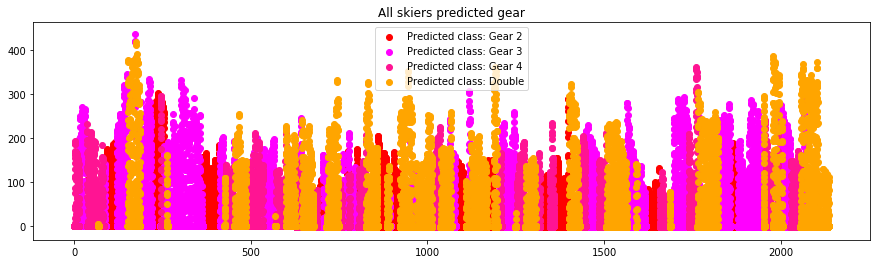

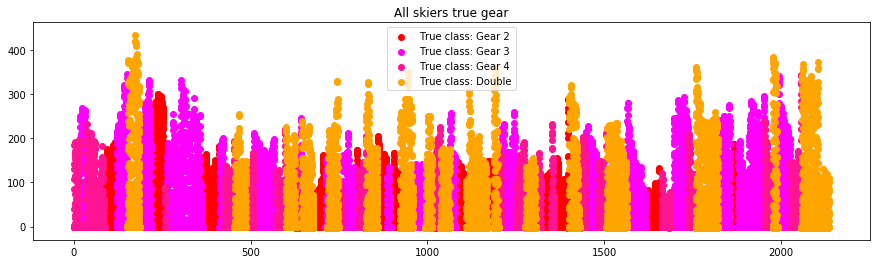

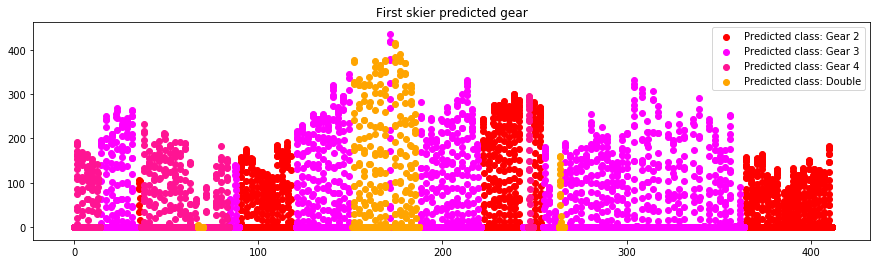

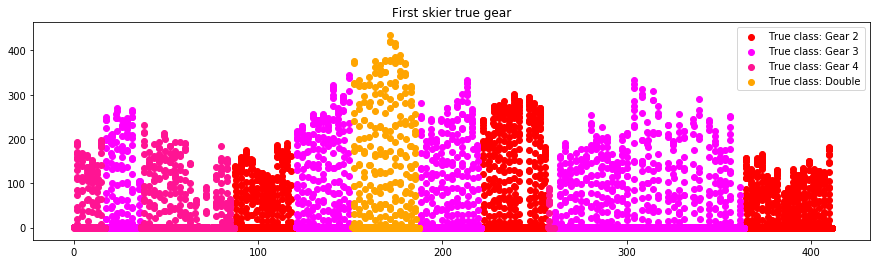

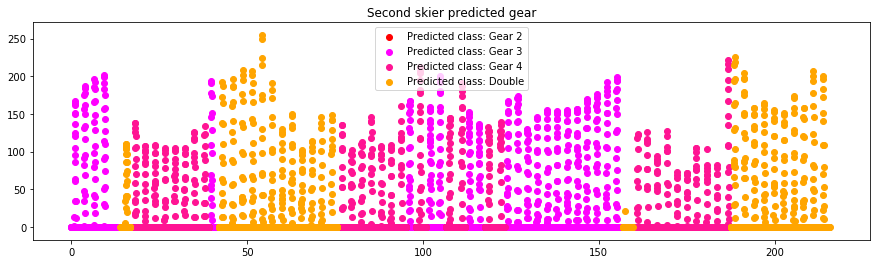

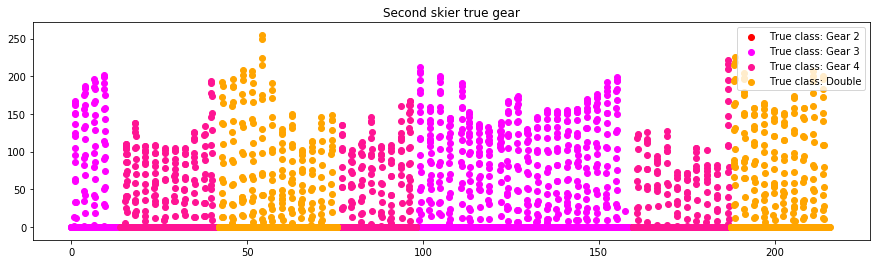

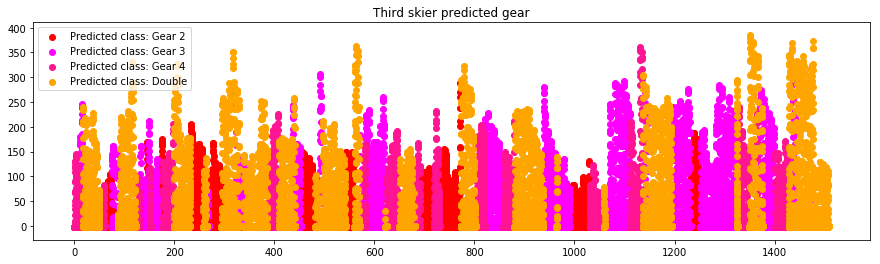

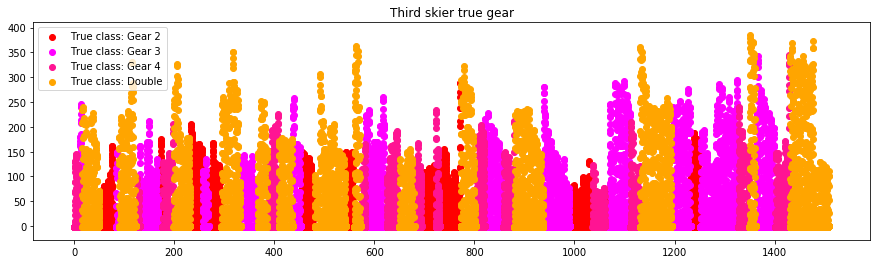

In [24]:
title_List = ['All skiers','First skier','Second skier','Third skier']
figure = 0
for i in range(len(X_Test_List)):
    X_Test_Skirer = X_Test_List[i]
    Y_Test_Skirer = Y_Test_List[i]
    predY = model.predict(X_Test_Skirer[:,:,1:])
    pred_Y = np.argmax(predY,axis = 1)
    true_Y = np.argmax(Y_Test_Skirer,axis = 1)
    acc = accuracy_score(true_Y,pred_Y)
    print('Accuracy ' + title_List[i] + ': %.2f '% acc)
    print(X_Test_Skirer.shape)
    title = title_List[i]
    figure = plot_Results(X_Test_Skirer,true_Y,pred_Y,figure,title)